In [84]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Load the dataset
dfs = pd.read_excel('accumulative_metrics_per_assignment.xlsx', sheet_name=None)

In [85]:
# Select only the suffrage passage
dfs = {'Suffrage': dfs['Suffrage']}

In [86]:
# Preprocessing
## Combine all assignments into one dataframe
assignment_names = ['Suffrage', 'Ants', 'Clouds', 'Waterclocks', 'Lizards', 'Tastes', 'Lodgepoles']
all_dfs = []
for assignment_name, df in dfs.items():
    # Drop unnecessary columns
    new_df = df.drop(columns=['group', 'id', f"{assignment_name}.data_loss", f"{assignment_name}.session_count"])

    # Drop all nan rows
    new_df = new_df.dropna()

    # Rename columns from f"{assignment_name}.<metric>" to f"<metric>"
    new_df.columns = [col.replace(f"{assignment_name}.", "") for col in new_df.columns]

    # Only keep the following metrics that include the following in their name
    all_dfs.append(new_df)

# Concatenate all dataframes
all_df = pd.concat(all_dfs)
all_df

,total_dwell_time_pdf,total_fix_count_pdf,total_fix_count,total_fix_count_quiz,coldread_saccade_line_regression_rate_%,coldread_saccade_horizontal_later_%,coldread_dwell_time_pdf,coldread_coverage_quote_%,coldread_fix_dispersion_std,coldread_fix_count_pdf,...,qa_coverage_page_%,qa_fix_count_quiz,qa_saccade_horizontal_later_%,qa_saccade_length_cm,qa_coverage_paragraph_%,qa_saccade_regression_rate_%,qa_dwell_time_pdf,qa_saccade_vertical_next_target_%,valor MAP,score
0,422.11,1907,3827,1789,11.31,38.31,135.08,100,0.79,589,...,100.00,1789,16.69,2.32,100.00,12.58,287.04,27.69,220,0.666667
1,424.00,739,1534,706,4.52,15.82,183.95,100,1.23,324,...,100.00,706,6.78,2.71,100.00,11.27,240.05,11.10,189,0.444444
3,234.44,1147,2719,1319,3.12,18.12,83.68,100,1.54,141,...,100.00,1319,7.50,2.78,100.00,12.47,150.77,14.03,214,0.444444
6,398.68,1313,2281,795,6.48,35.56,106.48,100,1.23,534,...,100.00,794,11.37,3.67,100.00,14.82,292.21,19.87,219,0.500000
7,65.74,165,1052,765,2.70,2.70,14.00,0,1.87,37,...,66.67,764,3.89,3.08,66.67,3.07,51.74,5.73,190,0.444444
8,531.32,1982,4551,2439,7.17,54.73,421.06,100,1.01,1538,...,100.00,2439,3.90,2.06,100.00,4.57,110.26,6.15,201,0.555556
9,416.52,1182,2510,1099,6.85,29.91,287.73,100,1.05,788,...,100.00,1098,5.81,2.75,100.00,8.20,128.80,10.59,225,0.611111
10,250.48,893,1342,382,6.79,39.57,165.89,100,1.04,596,...,100.00,381,14.63,2.99,88.89,11.25,84.59,21.41,209,0.555556
11,463.05,2117,2994,803,10.07,56.15,299.14,100,0.99,1331,...,100.00,803,16.18,2.32,100.00,14.05,163.92,28.89,225,0.666667
13,1.65,6,333,286,0.00,0.00,0.60,0,0.22,3,...,33.33,286,0.00,2.48,11.11,0.31,1.05,0.00,195,0.166667


In [ ]:
# Split data into features and target
labels = ['valor MAP', 'score']
in_features = [col for col in all_df.columns if col not in labels]
X = all_df[in_features]
y = all_df['valor MAP'] # starting with the score

In [88]:
# First determine the correlation between the metrics and the final grade
# Calculate the correlation between the features and the target
correlation = X.corrwith(y)
correlation = correlation.sort_values(ascending=False)
correlation

coldread_saccade_line_regression_rate_%    0.420784
coldread_coverage_word_%                   0.409059
coldread_saccade_vertical_later_%          0.383450
qa_coverage_page_%                         0.367236
coldread_saccade_regression_rate_%         0.361400
coldread_coverage_line_%                   0.350780
coldread_fix_count                         0.327309
coldread_fix_count_pdf                     0.327282
qa_coverage_paragraph_%                    0.325254
coldread_coverage_quote_%                  0.311489
coldread_saccade_vertical_next_target_%    0.310620
total_fix_count_pdf                        0.283948
coldread_coverage_paragraph_%              0.278368
qa_coverage_heading_%                      0.228130
qa_coverage_title_%                        0.220965
total_fix_count                            0.209119
coldread_dwell_time_pdf                    0.207041
coldread_saccade_horizontal_later_%        0.206464
coldread_coverage_page_%                   0.198337
qa_saccade_h

In [89]:


# Split dataset
# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    "SVM": SVR(),
    "Decision Tree": DecisionTreeRegressor()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R²": r2}

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).T
results_df


,MAE,MSE,R²
Linear Regression,0.483020,0.335586,-9.873002
Random Forest,0.171173,0.041254,-0.336614
XGBoost,0.191405,0.051869,-0.680549
SVM,0.205834,0.061661,-0.997818
Decision Tree,0.216049,0.070988,-1.300000


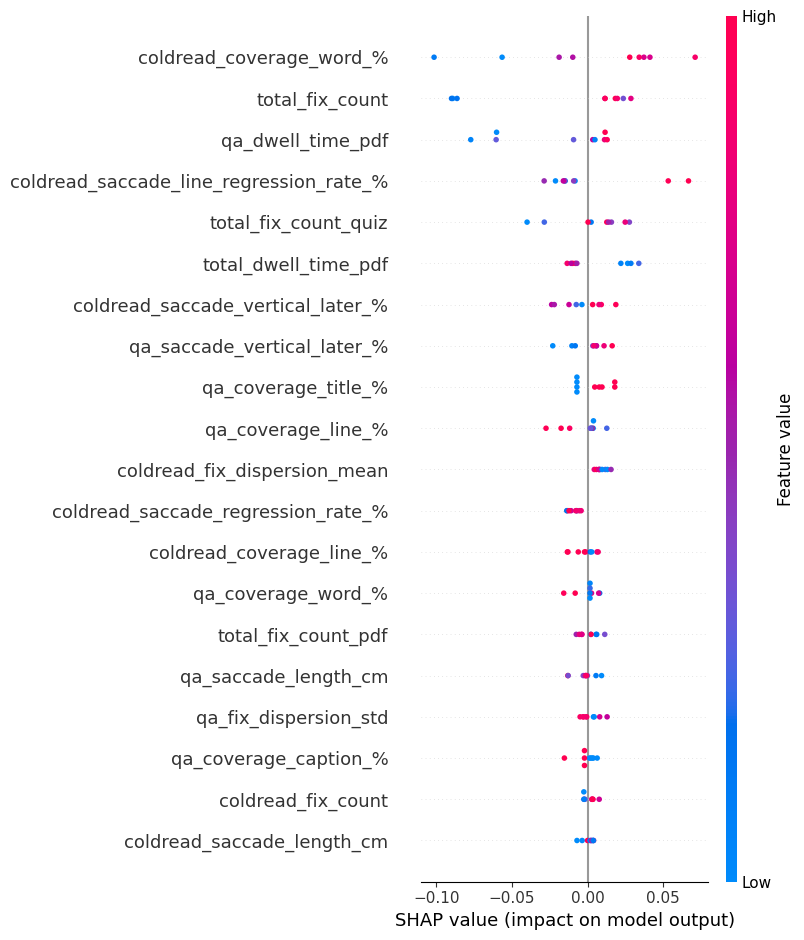

In [91]:
# Train the best model (choose based on R²)
best_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)

# Create SHAP explainer
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

# Visualize feature importance
shap.summary_plot(shap_values, X_test)

In [92]:
# Compute feature importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

feature_importance_df


,Feature,Importance
4,coldread_saccade_line_regression_rate_%,0.231616
19,coldread_saccade_vertical_later_%,0.149497
0,total_dwell_time_pdf,0.109947
30,qa_fix_dispersion_std,0.053757
26,qa_coverage_line_%,0.039960
24,qa_coverage_quote_%,0.031499
34,qa_fix_count_pdf,0.024748
10,coldread_coverage_line_%,0.021151
6,coldread_dwell_time_pdf,0.020056
25,qa_coverage_title_%,0.016158


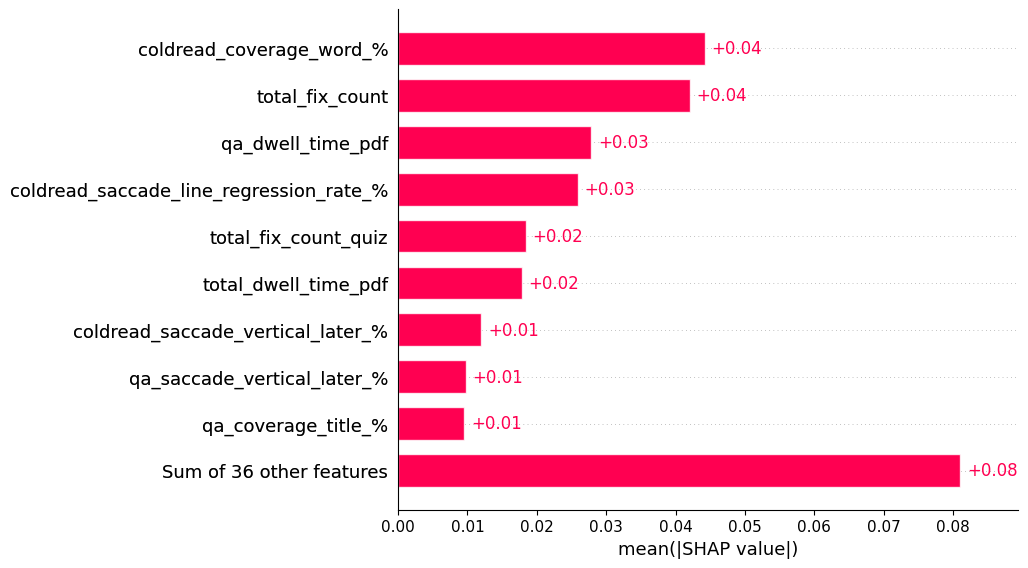

In [93]:
shap.plots.bar(shap_values)

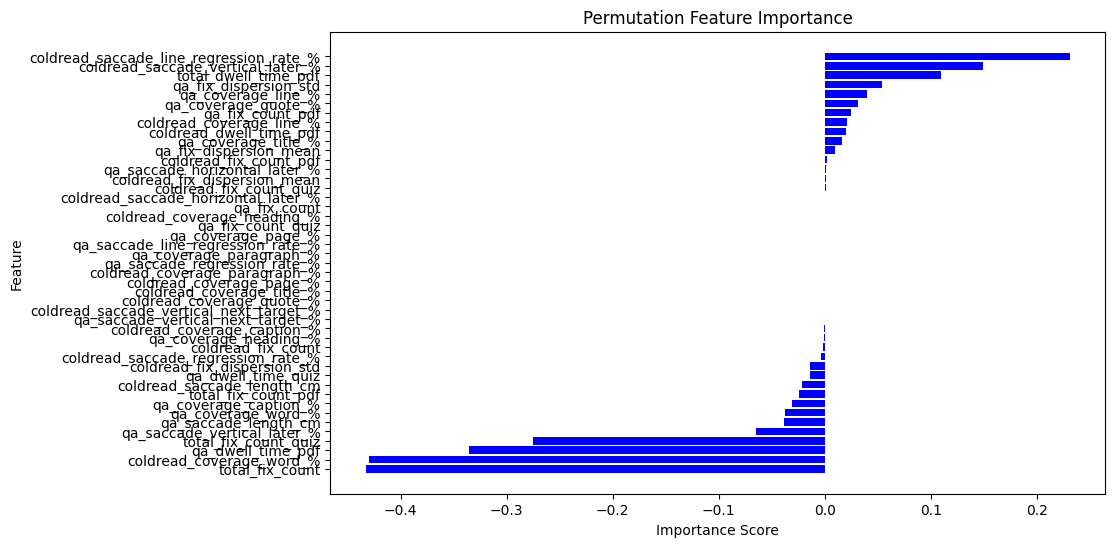

In [94]:
plt.figure(figsize=(10,6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="blue")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()
plt.show()